In [ ]:
#Code from the follwoing source has been referred to complete the assignment
#https://github.com/mayank171986/DONORS-CHOOSE-DT/blob/master/donors-choose-decision-tree.ipynb

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

import time
from tqdm import tqdm
import os
import pickle

import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('drive/My Drive/preprocessed_data.csv')
df.head(1)

school_state teacher_prefix project_grade_category  \
0           ca            mrs          grades_prek_2   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            53                    1   

  clean_categories                 clean_subcategories  \
0     math_science  appliedsciences health_lifescience   

                                               essay   price  
0  i fortunate enough use fairy tale stem kits cl...  725.05

In [ ]:
y = df['project_is_approved'].values 
df.drop(['project_is_approved'],axis = 1,inplace = True)
X = df
X.shape

(109248, 8)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,stratify = y)

In [ ]:
#now the test and cv split
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,test_size =0.3,stratify = y_train) 

In [ ]:
print("Train data:",X_train.shape,y_train.shape)
print("CV data:",X_cv.shape,y_cv.shape)
print("Test data:",X_test.shape,y_test.shape)

Train data: (53531, 8) (53531,)
CV data: (22942, 8) (22942,)
Test data: (32775, 8) (32775,)


one hot encoding

In [ ]:
#for school state 
my_counter=Counter()
for state in df['school_state'].values:
  my_counter.update(state.split())
school_state_dict=dict(my_counter)
sorted_school_state_dict= dict(sorted(school_state_dict.items(),key=lambda kv:kv[1]))
print(sorted_school_state_dict)

statelist=list(df['school_state'].values)
vectorizer_state= CountVectorizer(vocabulary=set(statelist),lowercase=False,binary=True)
vectorizer_state.fit(df['school_state'])

x_train_school_state_one_hot = vectorizer_state.transform(X_train['school_state'].values)
x_cv_school_state_one_hot = vectorizer_state.transform(X_cv['school_state'].values)
x_test_school_state_one_hot = vectorizer_state.transform(X_test['school_state'].values)

{'vt': 80, 'wy': 98, 'nd': 143, 'mt': 245, 'ri': 285, 'sd': 300, 'ne': 309, 'de': 343, 'ak': 345, 'nh': 348, 'wv': 503, 'me': 505, 'hi': 507, 'dc': 516, 'nm': 557, 'ks': 634, 'ia': 666, 'id': 693, 'ar': 1049, 'co': 1111, 'mn': 1208, 'or': 1242, 'ky': 1304, 'ms': 1323, 'nv': 1367, 'md': 1514, 'ct': 1663, 'tn': 1688, 'ut': 1731, 'al': 1762, 'wi': 1827, 'va': 2045, 'az': 2147, 'nj': 2237, 'ok': 2276, 'wa': 2334, 'ma': 2389, 'la': 2394, 'oh': 2467, 'mo': 2576, 'in': 2620, 'pa': 3109, 'mi': 3161, 'sc': 3936, 'ga': 3963, 'il': 4350, 'nc': 5091, 'fl': 6185, 'ny': 7318, 'tx': 7396, 'ca': 15388}


In [ ]:
print('train shape',x_train_school_state_one_hot.shape)
print('cv shape',x_cv_school_state_one_hot.shape)
print('test shape',x_test_school_state_one_hot.shape)

train shape (53531, 51)
cv shape (22942, 51)
test shape (32775, 51)


In [ ]:
#for categories
from collections import Counter
my_counter = Counter()
for word in df['clean_categories'].values:
  my_counter.update(word.split())

cat_dict = dict(my_counter) 
sorted_cat_dict= dict(sorted(cat_dict.items(), key=lambda kv: kv[1])) 
print(sorted_cat_dict)

{'warmth': 1388, 'care_hunger': 1388, 'history_civics': 5914, 'music_arts': 10293, 'appliedlearning': 12135, 'specialneeds': 13642, 'health_sports': 14223, 'math_science': 41421, 'literacy_language': 52239}


In [ ]:
vectorizer_cat= CountVectorizer(vocabulary=list(sorted_cat_dict.keys()),lowercase=False,binary=True)

vectorizer_cat.fit(X_train['clean_categories'].values)

x_train_categories_one_hot = vectorizer_cat.transform(X_train['clean_categories'].values)
x_test_categories_one_hot = vectorizer_cat.transform(X_test['clean_categories'].values)
x_cv_categories_one_hot = vectorizer_cat.transform(X_cv['clean_categories'].values)

print(vectorizer_cat.get_feature_names())
print("shape of train categories: ",x_train_categories_one_hot.shape)
print("shape of cv categories: ",x_cv_categories_one_hot.shape)
print("shape of test categories: ",x_test_categories_one_hot.shape)

['warmth', 'care_hunger', 'history_civics', 'music_arts', 'appliedlearning', 'specialneeds', 'health_sports', 'math_science', 'literacy_language']
shape of train categories:  (53531, 9)
shape of cv categories:  (22942, 9)
shape of test categories:  (32775, 9)


In [ ]:
#for sub categories
my_counter = Counter()
for word in df['clean_subcategories'].values:
  my_counter.update(word.split())

sub_cat_dict = dict(my_counter) 
sorted_sub_cat_dict= dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1])) 
print(sorted_sub_cat_dict)
vectorizer_sub_cat= CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()),lowercase=False,binary=True)

vectorizer_sub_cat.fit(X_train['clean_subcategories'].values)

x_train_sub_categories_one_hot = vectorizer_sub_cat.transform(X_train['clean_subcategories'].values)
x_test_sub_categories_one_hot = vectorizer_sub_cat.transform(X_test['clean_subcategories'].values)
x_cv_sub_categories_one_hot = vectorizer_sub_cat.transform(X_cv['clean_subcategories'].values)

print(vectorizer_sub_cat.get_feature_names())

{'economics': 269, 'communityservice': 441, 'financialliteracy': 568, 'parentinvolvement': 677, 'extracurricular': 810, 'civics_government': 815, 'foreignlanguages': 890, 'nutritioneducation': 1355, 'warmth': 1388, 'care_hunger': 1388, 'socialsciences': 1920, 'performingarts': 1961, 'charactereducation': 2065, 'teamsports': 2192, 'other': 2372, 'college_careerprep': 2568, 'music': 3145, 'history_geography': 3171, 'health_lifescience': 4235, 'earlydevelopment': 4254, 'esl': 4367, 'gym_fitness': 4509, 'environmentalscience': 5591, 'visualarts': 6278, 'health_wellness': 10234, 'appliedsciences': 10816, 'specialneeds': 13642, 'literature_writing': 22179, 'mathematics': 28074, 'literacy': 33700}
['economics', 'communityservice', 'financialliteracy', 'parentinvolvement', 'extracurricular', 'civics_government', 'foreignlanguages', 'nutritioneducation', 'warmth', 'care_hunger', 'socialsciences', 'performingarts', 'charactereducation', 'teamsports', 'other', 'college_careerprep', 'music', 'hist

In [ ]:
print("shape of train sub categories: ",x_train_sub_categories_one_hot.shape)
print("shape of cv sub categories: ",x_cv_sub_categories_one_hot.shape)
print("shape of test sub categories: ",x_test_sub_categories_one_hot.shape)

shape of train sub categories:  (53531, 30)
shape of cv sub categories:  (22942, 30)
shape of test sub categories:  (32775, 30)


In [ ]:
#for project grade
my_counter = Counter()
for word in df['project_grade_category'].values:
    my_counter.update(word.split())
    
grade_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(grade_dict.items(), key=lambda kv: kv[1]))
print(sorted_project_grade_cat_dict)
vectorizer_grade = CountVectorizer(vocabulary=list(sorted_project_grade_cat_dict.keys()), lowercase=False, binary=True)

vectorizer_grade.fit(X_train['project_grade_category'].values)

x_train_grade_category_one_hot = vectorizer_grade.transform(X_train['project_grade_category'].values)
x_cv_grade_category_one_hot    = vectorizer_grade.transform(X_cv['project_grade_category'].values)
x_test_grade_category_one_hot  = vectorizer_grade.transform(X_test['project_grade_category'].values)

print(vectorizer_grade.get_feature_names())

{'grades_9_12': 10963, 'grades_6_8': 16923, 'grades_3_5': 37137, 'grades_prek_2': 44225}
['grades_9_12', 'grades_6_8', 'grades_3_5', 'grades_prek_2']


In [ ]:
print('train shape',x_train_grade_category_one_hot.shape)
print('cv shape',x_cv_grade_category_one_hot.shape)
print('test shape',x_test_grade_category_one_hot.shape)

train shape (53531, 4)
cv shape (22942, 4)
test shape (32775, 4)


In [ ]:
#for teacher prefixes
my_counter = Counter()
for prefix in df['teacher_prefix'].values:
    prefix = str(prefix).lower().replace('.','').strip()
    
    my_counter.update(prefix.split())
teacher_prefix_cat_dict = dict(my_counter)
sorted_teacher_prefix_cat_dict = dict(sorted(teacher_prefix_cat_dict.items(), key=lambda kv: kv[1]))
print(sorted_teacher_prefix_cat_dict)
vectorizer_prefix = CountVectorizer(vocabulary=list(sorted_teacher_prefix_cat_dict.keys()), lowercase=False, binary=True)

vectorizer_prefix.fit(X_train['teacher_prefix'].values)

x_train_prefix_one_hot = vectorizer_prefix.transform(X_train['teacher_prefix'].values)
x_cv_prefix_one_hot    = vectorizer_prefix.transform(X_cv['teacher_prefix'].values)
x_test_prefix_one_hot  = vectorizer_prefix.transform(X_test['teacher_prefix'].values)

print(vectorizer_prefix.get_feature_names())

{'dr': 13, 'teacher': 2360, 'mr': 10648, 'ms': 38955, 'mrs': 57272}
['dr', 'teacher', 'mr', 'ms', 'mrs']


In [ ]:
print('train shape',x_train_prefix_one_hot.shape)
print('cv shape',x_cv_prefix_one_hot.shape)
print('test shape',x_test_prefix_one_hot.shape)

train shape (53531, 5)
cv shape (22942, 5)
test shape (32775, 5)


TFIDF Vectorizer

In [ ]:
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['essay'].values) 


X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)


In [ ]:
print("Train data:",X_train_essay_tfidf.shape,y_train.shape)
print("CV data:",X_cv_essay_tfidf.shape,y_cv.shape)
print("Test data:",X_test_essay_tfidf.shape,y_test.shape)

Train data: (53531, 12532) (53531,)
CV data: (22942, 12532) (22942,)
Test data: (32775, 12532) (32775,)


tfidf w2v

In [ ]:
with open('drive/My Drive/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
tfidf_vectorizer=TfidfVectorizer()
tfidf_vectorizer.fit(X_train['essay'])

TfidfVectorizer()

In [ ]:
tfidf_dict=dict(zip(tfidf_vectorizer.get_feature_names(),list(tfidf_vectorizer.idf_))) #in this dictionary we will have a tfidf word and its correspodning idf score 
tfidf_words = set(tfidf_vectorizer.get_feature_names())

In [ ]:
X_train_tfidf_w2v = []
for sent in tqdm(X_train['essay'].values):
  vector = np.zeros(300)
  tf_idf_weight =0
  for word in sent.split():
    if (word in glove_words) and (word in tfidf_words):
      vec = model[word]
      tf_idf = tfidf_dict[word]*(sent.count(word)/len(sent.split()))
      vector += (vec*tf_idf)  #this gives us the weighted tfidf value
      tf_idf_weight += tf_idf
  if tf_idf_weight != 0:
    vector /= tf_idf_weight    
  X_train_tfidf_w2v.append(vector)

100%|██████████| 53531/53531 [02:14<00:00, 399.35it/s]


In [ ]:
print(len( X_train_tfidf_w2v))
print(len( X_train_tfidf_w2v[0]))

53531
300


In [ ]:
X_train_tfidf_w2v = np.array(X_train_tfidf_w2v)

In [ ]:
X_train_tfidf_w2v = pd.DataFrame(X_train_tfidf_w2v)

In [ ]:
X_cv_tfidf_w2v = []
for sent in tqdm(X_cv['essay']):
  vector = np.zeros(300)
  tf_idf_weight =0
  for word in sent.split():
    if (word in glove_words) and (word in tfidf_words):
      vec = model[word]
      tf_idf = tfidf_dict[word]*(sent.count(word)/len(sent.split()))
      vector += (vec*tf_idf)  #this gives us the weighted tfidf value
      tf_idf_weight += tf_idf
  if tf_idf_weight != 0:
    vector /= tf_idf_weight    
  X_cv_tfidf_w2v.append(vector)

100%|██████████| 22942/22942 [00:56<00:00, 406.84it/s]


In [ ]:
print(len( X_cv_tfidf_w2v))
print(len( X_cv_tfidf_w2v[0]))

22942
300


In [ ]:
X_test_tfidf_w2v = []
for sent in tqdm(X_test['essay']):
  vector = np.zeros(300)
  tf_idf_weight =0
  for word in sent.split():
    if (word in glove_words) and (word in tfidf_words):
      vec = model[word]
      tf_idf = tfidf_dict[word]*(sent.count(word)/len(sent.split()))
      vector += (vec*tf_idf)  #this gives us the weighted tfidf value
      tf_idf_weight += tf_idf
  if tf_idf_weight != 0:
    vector /= tf_idf_weight    
  X_test_tfidf_w2v.append(vector)

100%|██████████| 32775/32775 [01:32<00:00, 353.51it/s]


In [ ]:
print(len( X_test_tfidf_w2v))
print(len( X_test_tfidf_w2v[0]))

32775
300


Numerical features

In [ ]:
X_train_price = X_train['price'].values.reshape(-1,1)
X_cv_price = X_cv['price'].values.reshape(-1,1)
X_test_price = X_test['price'].values.reshape(-1,1)

In [ ]:
X_train_price.shape

(53531, 1)

In [ ]:
X_train_prev_projects = X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
X_cv_prev_projects = X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
X_test_prev_projects = X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
senti_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
import pandas as pd

In [ ]:
for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
for_sentiment1 ='in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
list_of = [for_sentiment,for_sentiment1]
list_of_ss=[]
for i in list_of:

  ss = senti_analyzer.polarity_scores(i)
  list_of_ss.append(ss)
  
dfz=pd.DataFrame(list_of_ss)
print(dfz)

     neg    neu    pos  compound
0  0.010  0.745  0.245    0.9975
1  0.006  0.747  0.247    0.9950


In [ ]:
list_s_scores=[]
for essays in X_train['essay'].values:
  s_scores = senti_analyzer.polarity_scores(essays)
  list_s_scores.append(s_scores)

In [ ]:
X_train_senti_scores = pd.DataFrame(list_s_scores)

In [ ]:
print(X_train_senti_scores)

         neg    neu    pos  compound
0      0.036  0.642  0.322    0.9971
1      0.029  0.773  0.198    0.9918
2      0.020  0.831  0.149    0.9788
3      0.066  0.737  0.198    0.9575
4      0.026  0.706  0.268    0.9850
...      ...    ...    ...       ...
53526  0.023  0.617  0.360    0.9983
53527  0.048  0.750  0.202    0.9569
53528  0.020  0.694  0.286    0.9906
53529  0.011  0.632  0.358    0.9971
53530  0.000  0.675  0.325    0.9950

[53531 rows x 4 columns]


In [ ]:
list_s_scores_test = []
for essays in X_test['essay'].values:
  s_scores = senti_analyzer.polarity_scores(essays)
  list_s_scores_test.append(s_scores)

In [ ]:
X_test_senti_scores = pd.DataFrame(list_s_scores_test)

In [ ]:
print(X_test_senti_scores)

         neg    neu    pos  compound
0      0.052  0.700  0.248    0.9796
1      0.098  0.727  0.176    0.9230
2      0.056  0.698  0.246    0.9850
3      0.035  0.627  0.338    0.9971
4      0.021  0.803  0.175    0.9838
...      ...    ...    ...       ...
32770  0.046  0.777  0.177    0.9601
32771  0.033  0.599  0.368    0.9931
32772  0.030  0.654  0.316    0.9930
32773  0.000  0.739  0.261    0.9869
32774  0.109  0.595  0.296    0.9837

[32775 rows x 4 columns]


In [ ]:
list_s_scores_cv=[]
for essays in X_cv['essay'].values:
  s_scores = senti_analyzer.polarity_scores(essays)
  list_s_scores_cv.append(s_scores)

In [ ]:
X_cv_senti_scores = pd.DataFrame(list_s_scores_cv)

In [ ]:
print(X_cv_senti_scores)

         neg    neu    pos  compound
0      0.034  0.675  0.291    0.9939
1      0.029  0.695  0.276    0.9908
2      0.065  0.603  0.333    0.9920
3      0.078  0.697  0.225    0.9914
4      0.011  0.753  0.236    0.9864
...      ...    ...    ...       ...
22937  0.063  0.678  0.259    0.9661
22938  0.020  0.652  0.328    0.9882
22939  0.075  0.658  0.267    0.9918
22940  0.038  0.739  0.223    0.9905
22941  0.024  0.803  0.172    0.9423

[22942 rows x 4 columns]


Confusion_matrix

In [ ]:
def conf_matrix(clf,X_test,y_test):
  y_pred = clf.predict(X_test)
  conf_mat = pd.DataFrame(confusion_matrix(y_test,y_pred),range(2),range(2))
  conf_mat.columns = ['Predicted No','Predicted Yes']
  conf_mat = conf_mat.rename({0: 'Actual No',1: 'actual Yes'})
  sns.set(font_scale=1.4)
  sns.heatmap(conf_mat,annot = True,annot_kws={'size':16},fmt='g')

In [ ]:
def get_prediction(prob, threshould, fpr, tpr):
    predictions = []
    t = threshould[np.argmax(fpr*(1-tpr))]
    for i in prob:
        if(i>=t):
            predictions.append(1)
        else:
            predictions.append(0)  
    return predictions

In [ ]:
def get_fpr(y_test,y_pred):
  fpr = []
  for i in range(len(y_test)):
    if (y_test[i] == 0 and y_pred[i]==1):
      fpr.append(i)
  return fpr    

To merge all the features

In [ ]:
from scipy.sparse import hstack

In [ ]:
x_train_onehot=hstack((x_train_categories_one_hot,x_train_sub_categories_one_hot,x_train_school_state_one_hot,x_train_prefix_one_hot,x_train_grade_category_one_hot,X_train_price,X_train_prev_projects))
x_test_onehot=hstack((x_test_categories_one_hot,x_test_sub_categories_one_hot,x_test_school_state_one_hot,x_test_prefix_one_hot,x_test_grade_category_one_hot,X_test_price,X_test_prev_projects))
x_cv_onehot=hstack((x_cv_categories_one_hot,x_cv_sub_categories_one_hot,x_cv_school_state_one_hot,x_cv_prefix_one_hot,x_cv_grade_category_one_hot,X_cv_price,X_cv_prev_projects))

In [ ]:
print(x_train_onehot.shape)
print(x_test_onehot.shape)
print(x_cv_onehot.shape)

(53531, 101)
(32775, 101)
(22942, 101)


Set 1

In [ ]:
x_train_onehot_tfidf = hstack((x_train_onehot,X_train_essay_tfidf))
print(x_train_onehot_tfidf.shape)
x_train_onehot_tfidf.tocsr()

x_test_onehot_tfidf = hstack((x_test_onehot,X_test_essay_tfidf))
print(x_test_onehot_tfidf.shape)
x_test_onehot_tfidf.tocsr()

x_cv_onehot_tfidf = hstack((x_cv_onehot,X_cv_essay_tfidf))
print(x_cv_onehot_tfidf.shape)
x_cv_onehot_tfidf.tocsr()

(53531, 12633)
(32775, 12633)
(22942, 12633)


<22942x12633 sparse matrix of type '<class 'numpy.float64'>'
	with 2626897 stored elements in Compressed Sparse Row format>

In [ ]:
X_train_tfidf_final=hstack((x_train_onehot_tfidf,X_train_senti_scores))
print(X_train_tfidf_final.shape)

X_test_tfidf_final=hstack((x_test_onehot_tfidf,X_test_senti_scores))
print(X_test_tfidf_final.shape)

X_cv_tfidf_final=hstack((x_cv_onehot_tfidf,X_cv_senti_scores))
print(X_cv_tfidf_final.shape)

(53531, 12637)
(32775, 12637)
(22942, 12637)


set 2

In [ ]:
x_train_onehot_tfidf_w2v = hstack((x_train_onehot,X_train_tfidf_w2v))
print(x_train_onehot_tfidf_w2v.shape)
x_train_onehot_tfidf_w2v.tocsr()

x_test_onehot_tfidf_w2v = hstack((x_test_onehot,X_test_tfidf_w2v))
print(x_test_onehot_tfidf_w2v.shape)
x_test_onehot_tfidf_w2v.tocsr()

x_cv_onehot_tfidf_w2v = hstack((x_cv_onehot,X_cv_tfidf_w2v))
print(x_cv_onehot_tfidf_w2v.shape)
x_cv_onehot_tfidf_w2v.tocsr()


(53531, 401)
(32775, 401)
(22942, 401)


<22942x401 sparse matrix of type '<class 'numpy.float64'>'
	with 7059939 stored elements in Compressed Sparse Row format>

In [ ]:
X_train_tfidf_w2v_final=hstack((x_train_onehot_tfidf_w2v,X_train_senti_scores))
print(X_train_tfidf_w2v_final.shape)

X_test_tfidf_w2v_final=hstack((x_test_onehot_tfidf_w2v,X_test_senti_scores))
print(X_test_tfidf_w2v_final.shape)

X_cv_tfidf_w2v_final=hstack((x_cv_onehot_tfidf_w2v,X_cv_senti_scores))
print(X_cv_tfidf_w2v_final.shape)

(53531, 405)
(32775, 405)
(22942, 405)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve, GridSearchCV

On SET 1:

In [ ]:
dt = DecisionTreeClassifier(class_weight='balanced')
parameters = {'max_depth':[1, 3, 10, 30], 'min_samples_split':[5, 10, 100, 500]}
clf=GridSearchCV(dt, parameters, cv=3, scoring='roc_auc', n_jobs=-1, return_train_score=True)
clf.fit(X_train_tfidf_final, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [ ]:
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)
print(clf.score(X_train_tfidf_final,y_train))

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)
{'max_depth': 10, 'min_samples_split': 500}
0.6363102109436004
0.7133398440476018


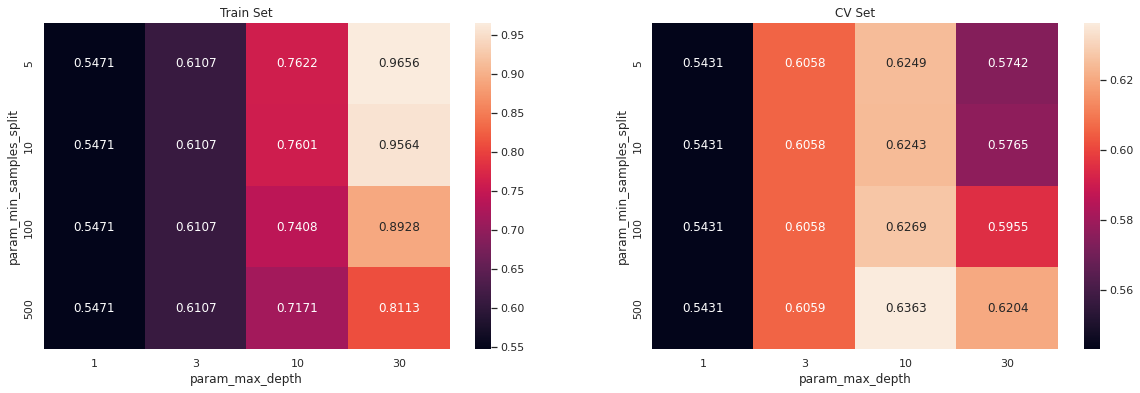

In [ ]:
import seaborn as sns; sns.set()
max_scores = pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

ROC curve

In [ ]:
#taking these parameter values as variables because they cant be passed as int
max_depth = 10
min_samples_split = 500

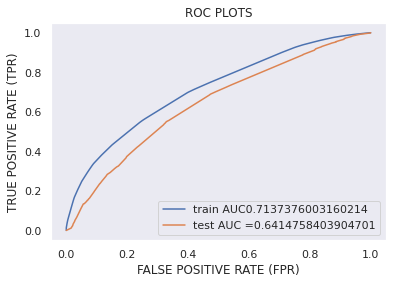

In [ ]:
DT_params = {'max_depth':[max_depth],'min_samples_split':[min_samples_split]}
dec_tree = DecisionTreeClassifier(class_weight='balanced',max_depth = max_depth,min_samples_split=min_samples_split)
dec_tree.fit(X_train_tfidf_final,y_train)

y_train_pred=dec_tree.predict_proba(X_train_tfidf_final)[:,1]
y_test_pred=dec_tree.predict_proba(X_test_tfidf_final)[:,1]


train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)


plt.plot(train_fpr,train_tpr,label = 'train AUC'+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE (FPR)")
plt.ylabel("TRUE POSITIVE RATE (TPR)")
plt.title("ROC PLOTS")
plt.grid()
plt.show()

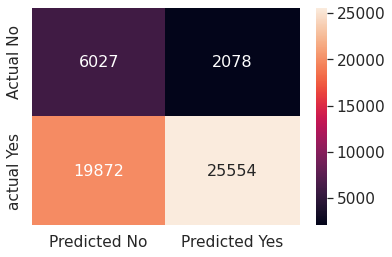

In [ ]:
conf_matrix(dec_tree,X_train_tfidf_final,y_train)

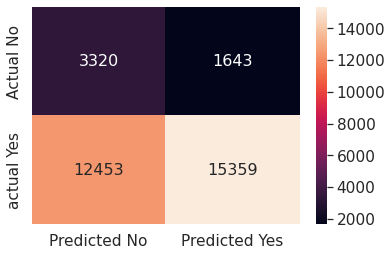

In [ ]:
conf_matrix(dec_tree,X_test_tfidf_final,y_test)

In [ ]:
predictions = get_prediction(y_test_pred, te_thresholds, test_fpr, test_tpr)

# train_fpr, train_tpr, tr_thresholds
fpr = get_fpr(y_test, predictions)

essay = X_test['essay'].to_frame()
essay = essay.reset_index()

price = X_test['price'].to_frame()
price = price.reset_index()

teacher_number_of_previously_posted_projects = X_test['teacher_number_of_previously_posted_projects'].to_frame()
teacher_number_of_previously_posted_projects = teacher_number_of_previously_posted_projects.reset_index()

false_essays = []
false_price = []
false_teacher_number_of_previously_posted_projects = []
for i in fpr:
    false_essays.append(essay.values[i][1:][0])
    false_price.append(price.values[i][1:][0])
    false_teacher_number_of_previously_posted_projects.append(teacher_number_of_previously_posted_projects.values[i][1:][0])
        

Wordcloud

In [ ]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/

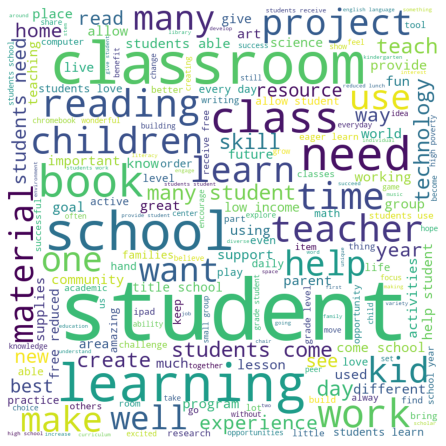

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
comment_words = ' '
stopwords = set(STOPWORDS)
for val in false_essays:
    val = str(val)
    val = val.lower()
    tokens = val.split()
    for words in tokens:
        if(words == 'nan' or words == 'nannan'):
            continue
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

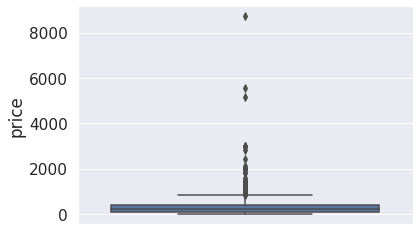

In [ ]:
df1 = pd.DataFrame({'price':false_price})
sns.boxplot(y='price', data=df1)

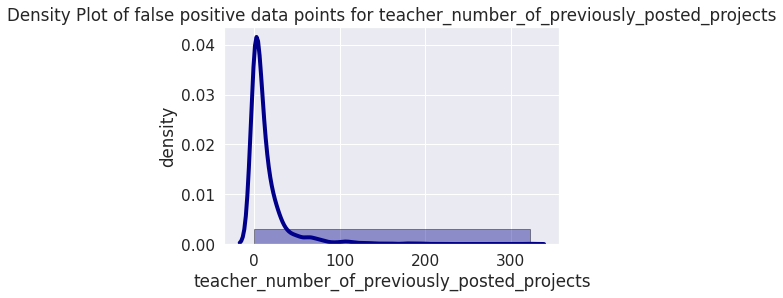

In [ ]:
sns.distplot(false_teacher_number_of_previously_posted_projects, hist=True, kde=True, 
             bins=1, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title('Density Plot of false positive data points for teacher_number_of_previously_posted_projects') 
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.ylabel('density')
plt.show()

On SET 2: TF-IDF W2V

In [ ]:
dt = DecisionTreeClassifier(class_weight='balanced')
parameters = {'max_depth':[1, 3, 10, 30], 'min_samples_split':[5, 10, 100, 500]}
clf=GridSearchCV(dt, parameters, cv=3, scoring='roc_auc', n_jobs=-1, return_train_score=True)
clf.fit(X_train_tfidf_w2v_final, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [ ]:
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)
print(clf.score(X_train_tfidf_w2v_final,y_train))

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)
{'max_depth': 10, 'min_samples_split': 500}
0.6247781516395369
0.7361238198736246


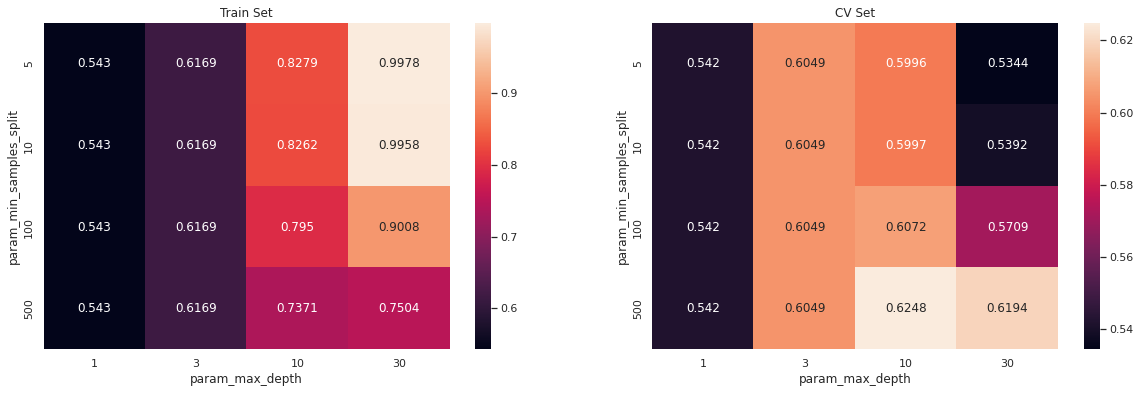

In [ ]:
import seaborn as sns; sns.set()
max_scores = pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

ROC Curve

In [ ]:
max_depth = 10
min_samples_split = 500

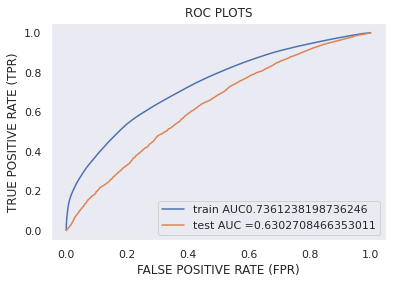

In [ ]:
DT_params = {'max_depth':[max_depth],'min_samples_split':[min_samples_split]}
dec_tree = DecisionTreeClassifier(class_weight='balanced',max_depth = max_depth,min_samples_split=min_samples_split)
dec_tree.fit(X_train_tfidf_w2v_final,y_train)

y_train_pred=dec_tree.predict_proba(X_train_tfidf_w2v_final)[:,1]
y_test_pred=dec_tree.predict_proba(X_test_tfidf_w2v_final)[:,1]


train_fpr,train_tpr,tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,te_thresholds = roc_curve(y_test,y_test_pred)


plt.plot(train_fpr,train_tpr,label = 'train AUC'+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE (FPR)")
plt.ylabel("TRUE POSITIVE RATE (TPR)")
plt.title("ROC PLOTS")
plt.grid()
plt.show()

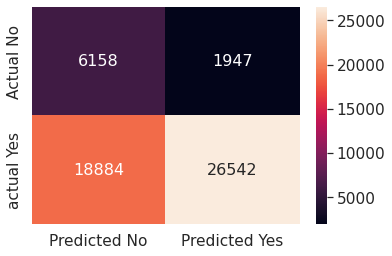

In [ ]:
conf_matrix(dec_tree,X_train_tfidf_w2v_final,y_train)

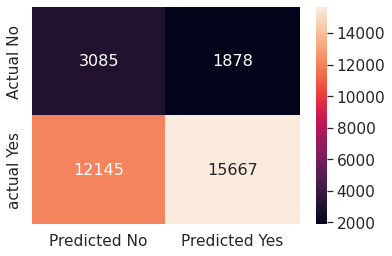

In [ ]:
conf_matrix(dec_tree,X_test_tfidf_w2v_final,y_test)

In [ ]:
predictions = get_prediction(y_test_pred, te_thresholds, test_fpr, test_tpr)

# train_fpr, train_tpr, tr_thresholds
fpr = get_fpr(y_test, predictions)

essay = X_test['essay'].to_frame()
essay = essay.reset_index()

price = X_test['price'].to_frame()
price = price.reset_index()

teacher_number_of_previously_posted_projects = X_test['teacher_number_of_previously_posted_projects'].to_frame()
teacher_number_of_previously_posted_projects = teacher_number_of_previously_posted_projects.reset_index()

false_essays = []
false_price = []
false_teacher_number_of_previously_posted_projects = []
for i in fpr:
    false_essays.append(essay.values[i][1:][0])
    false_price.append(price.values[i][1:][0])
    false_teacher_number_of_previously_posted_projects.append(teacher_number_of_previously_posted_projects.values[i][1:][0])
        

WordCloud

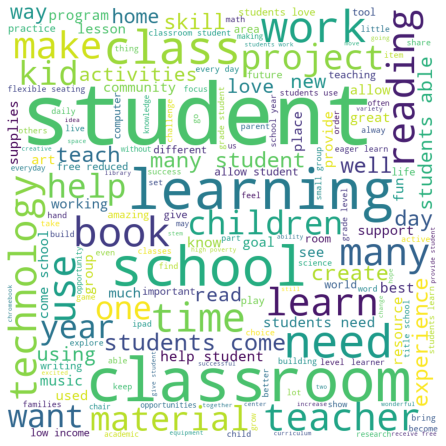

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
comment_words = ' '
stopwords = set(STOPWORDS)
for val in false_essays:
    val = str(val)
    val = val.lower()
    tokens = val.split()
    for words in tokens:
        if(words == 'nan' or words == 'nannan'):
            continue
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

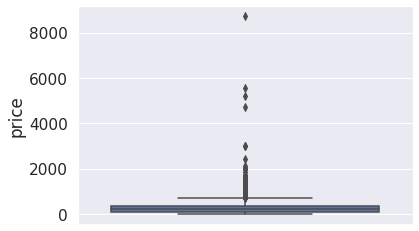

In [ ]:
df1 = pd.DataFrame({'price':false_price})
sns.boxplot(y='price', data=df1)

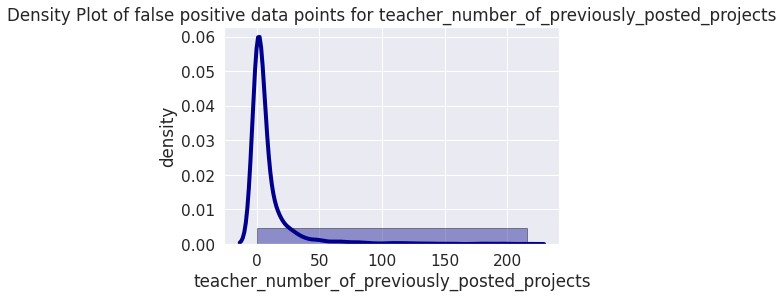

In [ ]:
sns.distplot(false_teacher_number_of_previously_posted_projects, hist=True, kde=True, 
             bins=1, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title('Density Plot of false positive data points for teacher_number_of_previously_posted_projects') 
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.ylabel('density')
plt.show()

OBSERVATIONS:


*   We can see the  from the WordCloud that set 1 and set 2 results are almost same but there are some key differences. Words like 'many', 'day' etc are in different popularity of  words.




Task 2: 

In [ ]:
dec1_tree = DecisionTreeClassifier(class_weight='balanced',max_depth = None,min_samples_split=min_samples_split)
dec1_tree.fit(X_train_tfidf_final,y_train)
#This clssifier is seperate but only with max_depth as None. Rest of the parameters are from the previously used classifier

DecisionTreeClassifier(class_weight='balanced', min_samples_split=500)

In [ ]:
feature_imps=dec1_tree.feature_importances_ 
indexes_nonzero=[]
for idx,nonzero_fea in enumerate(feature_imps):
  if nonzero_fea != 0:
    
    indexes_nonzero.append(idx)


In [ ]:
print(indexes_nonzero)

[14, 17, 25, 49, 62, 94, 99, 100, 104, 132, 134, 154, 177, 193, 212, 256, 283, 295, 349, 365, 415, 417, 434, 444, 451, 452, 463, 473, 491, 589, 658, 663, 673, 677, 693, 711, 754, 787, 869, 947, 951, 958, 960, 988, 990, 995, 996, 1025, 1036, 1057, 1060, 1097, 1102, 1137, 1149, 1155, 1186, 1190, 1195, 1215, 1270, 1285, 1307, 1343, 1354, 1393, 1464, 1466, 1499, 1521, 1543, 1570, 1572, 1610, 1622, 1624, 1675, 1680, 1681, 1699, 1732, 1733, 1748, 1770, 1775, 1800, 1834, 1862, 1864, 1883, 1952, 1987, 1996, 1997, 2010, 2015, 2117, 2139, 2154, 2169, 2202, 2203, 2206, 2254, 2283, 2298, 2300, 2324, 2347, 2388, 2438, 2484, 2486, 2488, 2493, 2514, 2531, 2582, 2634, 2681, 2704, 2723, 2731, 2783, 2819, 2872, 2894, 2927, 2938, 2946, 2971, 3015, 3016, 3152, 3217, 3219, 3235, 3254, 3273, 3274, 3280, 3323, 3344, 3503, 3539, 3574, 3577, 3647, 3667, 3670, 3750, 3752, 3758, 3762, 3774, 3784, 3802, 3823, 3839, 3860, 3917, 3960, 3963, 3982, 3989, 3991, 3994, 4010, 4016, 4029, 4037, 4078, 4116, 4133, 4137, 415

In [ ]:
X_train_tfidf_final1=X_train_tfidf_final.tocsr()

In [ ]:
X_train_fea_imp=[]
for i in range(len(indexes_nonzero)):
  X_train_fea_imp.append(X_train_tfidf_final1[i])


In [ ]:
y_train_fea_imp=[]
for j in range(len(indexes_nonzero)):
  y_train_fea_imp.append(y_train[j])

print(y_train_fea_imp)  

[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
print(len(X_train_fea_imp))
print(len(y_train_fea_imp))

544
544


In [ ]:
try:
  dt = DecisionTreeClassifier(class_weight='balanced')
  parameters = {'max_depth':[1, 3, 10, 30], 'min_samples_split':[5, 10, 100, 500]}
  clf=GridSearchCV(dt, parameters, cv=3, scoring='roc_auc', n_jobs=-1, return_train_score=True)
  clf.fit(X_train_fea_imp, y_train_fea_imp)
except ValueError:
  pass  

In [ ]:
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)


DecisionTreeClassifier(class_weight='balanced', max_depth=1,
                       min_samples_split=5)
{'max_depth': 1, 'min_samples_split': 5}
nan


In [ ]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Max Depth", "Min Samples Split", "Train AUC", "Test AUC"]

x.add_row(["TFIDF", "Decision Tree", 10, 500, 0.713, 0.641])

x.add_row(["TFIDF W2V", "Decision Tree", 10, 500, 0.736, 0.630])



print(x)

+------------+---------------+-----------+-------------------+-----------+----------+
| Vectorizer |     Model     | Max Depth | Min Samples Split | Train AUC | Test AUC |
+------------+---------------+-----------+-------------------+-----------+----------+
|   TFIDF    | Decision Tree |     10    |        500        |   0.713   |  0.641   |
| TFIDF W2V  | Decision Tree |     10    |        500        |   0.736   |   0.63   |
+------------+---------------+-----------+-------------------+-----------+----------+
